<a href="https://colab.research.google.com/github/icenicee/TP01/blob/main/pw5_image_restoration_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical Work 5: Image Restoration

<br/><br/>

In this practical session, you have to complete the code regions marked ``### ... ###``.

Also, you should write some comments in the textual cells.

In [1]:
import numpy as np
from torch.fft import fft2, ifft2, fftshift, ifftshift
import matplotlib.pyplot as plt
import torch
print(torch.__version__)

pi = torch.pi

def rgb2gray(u):
    return 0.2989 * u[:,:,0] + 0.5870 * u[:,:,1] + 0.1140 * u[:,:,2]

def str2(chars):
    return "{:.2f}".format(chars)

def psnr(uref,ut,M=1):
    mse = np.sqrt(np.mean((np.array(uref)-np.array(ut))**2))
    return 20*np.log10(M/mse)

# viewimage
import tempfile
import IPython
from skimage.transform import rescale

def viewimage(im, normalize=True,vmin=0,vmax=1,z=1,order=0,titre='',displayfilename=False):
    imin= im.numpy().astype(np.float32)
    channel_axis = 2 if len(im.shape)>2 else None
    if z!=1:
        from skimage.transform import rescale
        imin = rescale(imin, z, order=order, channel_axis=channel_axis)
    if normalize:
        if vmin is None:
            vmin = imin.min()
        if vmax is None:
            vmax = imin.max()
        if np.abs(vmax-vmin)>1e-10:
            imin = (imin.clip(vmin,vmax)-vmin)/(vmax-vmin)
        else:
            imin = vmin
    else:
        imin=imin.clip(0,255)/255
    imin=(imin*255).astype(np.uint8)
    filename=tempfile.mktemp(titre+'.png')
    if displayfilename:
        print (filename)
    plt.imsave(filename, imin, cmap='gray')
    IPython.display.display(IPython.display.Image(filename))


# alternative viewimage if the other one does not work:
def Viewimage(im,dpi=100,cmap='gray'):
    plt.figure(dpi=dpi)
    if cmap is None:
        plt.imshow(np.array(im))
    else:
        plt.imshow(np.array(im),cmap=cmap)
    plt.axis('off')
    plt.show()

!wget https://perso.telecom-paristech.fr/aleclaire/mva/tpdeblur.zip
!unzip tpdeblur.zip

2.8.0+cu126
--2025-11-18 15:33:42--  https://perso.telecom-paristech.fr/aleclaire/mva/tpdeblur.zip
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.22.227, 2a04:8ec0:0:a::89c2:16e3
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.22.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 774047 (756K) [application/zip]
Saving to: ‘tpdeblur.zip’

tpdeblur.zip        100%[===================>] 755.91K   780KB/s    in 1.0s    

2025-11-18 15:33:45 (780 KB/s) - ‘tpdeblur.zip’ saved [774047/774047]

Archive:  tpdeblur.zip
   creating: im/
  inflating: im/simpson512crop.png   
  inflating: im/simpson512.png       
  inflating: im/room.png             
  inflating: im/tshirt.png           
   creating: kernels/
  inflating: kernels/kernel_0.png    
  inflating: kernels/kernel_1.png    
  inflating: kernels/kernel_10.png   
  inflating: kernels/kernel_11.png   
  inflating: kernels/kernel_2.png    
  inflating: kern

## Wrapper for gradient descent

The following function allows to do a run of gradient descent on a function $f$ given as input.

In [4]:
def optim(f,niter=1000,lr=0.1):
    u = torch.randn(M,N, requires_grad=True)
    optimu = torch.optim.SGD([u], lr=lr)
    losslist = []
    for it in range(niter):
        loss = f(u)
        losslist.append(loss.detach())
        optimu.zero_grad()
        loss.backward()
        optimu.step()
    return u.detach(),losslist

## Generate the blurred image

First, we load a clean image that will serve for the whole practical session.

We will also load a blur kernel with which we will degrade the image. The goal of this session is to recover the clean image $u_0$ from a degraded version.

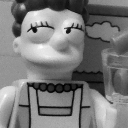

In [5]:
# Open the image as a torch.tensor
u0 = torch.tensor(rgb2gray(plt.imread('im/simpson512crop.png')))
M,N = u0.shape

viewimage(u0)

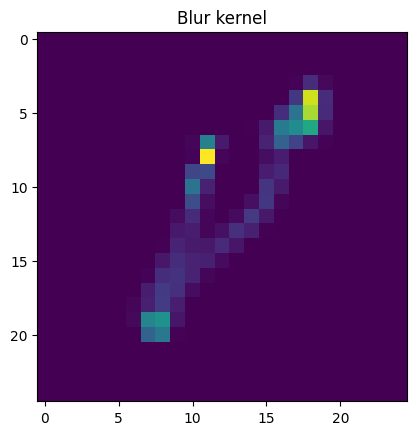

In [6]:
# Load a blur kernel
kt = torch.tensor(np.loadtxt('kernels/kernel8.txt'))
# kt = np.loadtxt('kernels/levin7.txt')
(m,n) = kt.shape

plt.imshow(kt)
plt.title('Blur kernel')
plt.show()

# Embed the kernel in a MxN image, and put center at pixel (0,0)
k = torch.zeros((M,N))
k[0:m,0:n] = kt/torch.sum(kt)
k = torch.roll(k,(-int(m/2),-int(n/2)),(0,1))
fk = fft2(k)

Compute the degraded image
$$ u_{\text{blur}} = k*u_0 + w $$
where $w$ is a Gaussian white noise of standard deviation $\sigma > 0$.

You will perform the convolution in Fourier domain (thus, with periodic boundary conditions).



In [ ]:
sigma = 0.02

fu0 = fft2(u0)
convolved_image = ifft2(fk * fu0).real
w = sigma * torch.randn_like(u0)
ublur = convolved_image + w

plt.figure(dpi=100)
plt.imshow(ublur,cmap='gray')
plt.title('Degraded image')
plt.axis('off')
plt.show()

## Naive Deblurring

Try to deblur the image by a naive method: in order to invert the convolution by $k$, you just divide in Fourier domain by $\hat{k}$.

What do you observe?

In [ ]:
### ... ###

# A) Deblurring with Tychonov regularization

Tychonov deblurring is obtained as the minimal point of the following functional
$$ F(u) = \frac{1}{2} \|k*u - u_{\text{blur}}\|_2^2 + \frac{\lambda}{2} \|\nabla u\|_2^2 $$
where the squared gradient norm is
$$ \|\nabla u\|_2^2 = \|\partial_1 u\|_2^2 + \|\partial_2 u\|_2^2 = \sum_{(x,y) \in \Omega} \partial_1 u(x,y)^2 + \partial_2 u(x,y)^2 .$$
The parameter $\lambda > 0$ allows to give more or less weight to the regularization.

For the derivatives $\partial_1 u, \partial_2 u$, you can use a simple discrete scheme, computed with periodic boundary conditions. (For that, you may use `torch.roll`).


- Implement the functional $F$.  ($\lambda$ will be defined as a global variable `lam`)

- Check the convergence of gradient descent by plotting the values of $F(u_n)$ along the iterations. (These values are given as output by `optim`.)

- Try to adjust the parameter $\lambda$. What do you observe when $\lambda$ is large?

In [ ]:
# Write the functional with data-fidelity and regularization with weight lam>0.  (lam will be defined as a global variable)
def F(u):
    ### ... ###


lam = 1
tau = ### ... ###

utych,losslist = ### ... ###

plt.figure(dpi=180)
plt.subplot(1,3,1)
plt.imshow(u0, cmap='gray')
plt.title('Original',fontsize=8)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(ublur, cmap='gray')
plt.title('Blurred \n PSNR='+str2(psnr(u0,v)),fontsize=8)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(utych, cmap='gray')
plt.title('Linear deblurring \n PSNR='+str2(psnr(u0,utych)),fontsize=8)
plt.axis('off')
plt.show()

plt.figure(dpi=100)
plt.plot(losslist)
plt.show()

Tychonov deblurring can also be computed with filtering, directly in the Fourier domain:

$$ \forall (\xi,\zeta) \in \Omega, \quad
    \widehat{u_{\text{tych}}}(\xi,\zeta) = \frac{\overline{\widehat{k}(\xi,\zeta)} }{|\widehat{k}(\xi,\zeta)|^2 + \lambda \ \hat{L}(\xi,\zeta) } \ \widehat{u_{\text{blur}}}(\xi,\zeta) $$
where

$$\hat{L}(\xi,\zeta) = 4  \left( \sin^2 \left(\frac{\pi \xi}{M} \right) +  \sin^2 \left(\frac{\pi \zeta}{N} \right) \right) .$$

- Compute Tychonov deblurring with this formula (you can use the predefined arrays below for $\xi$ and $\zeta$)
- Compare with the result obtained with gradient descent.
- Does this formula allow you to better understand what happends when you increase $\lambda$?

In [ ]:
xi = torch.arange(M)
ind = (xi>M/2)
xi[ind] = xi[ind]-M
zeta = torch.arange(N)
ind = (zeta>N/2)
zeta[ind] = zeta[ind]-N
Xi,Zeta = torch.meshgrid(xi,zeta,indexing='ij')

### ... ###

# A) Deblurring with $\mathsf{TV}_\varepsilon$ regularization

In the course session, we have defined the smoothed total variation as
$$ \mathsf{TV}_{\varepsilon}(u)
= \sum_{(x,y) \in \Omega} \sqrt{ \varepsilon^2 + \partial_1 u (x,y)^2 + \partial_2 u (x,y)^2 } \ .$$
where $\varepsilon > 0$ is a parameter.

$\mathsf{TV}_{\varepsilon}$-deblurring is obtained as the minimal point of the following functional
$$ G(u) = \frac{1}{2} \|k*u - u_{\text{blur}}\|_2^2 + \lambda \mathsf{TV}_{\varepsilon}(u) $$

- Implement $\mathsf{TV}_{\varepsilon}$-deblurring. For that, you will need to implement the function $G$ (again, $\lambda$ and $\varepsilon$ will be defined as global variables.)

- Try adjusting the parameter $\lambda$. How would you describe the deblurred image when $\lambda$ is large?

In [ ]:
def G(u):
    ### ... ###


lam = ### ... ###
ep = 0.01

tau = ### ... ###

### ... ###

plt.figure(dpi=180)
plt.subplot(1,3,1)
plt.imshow(u0, cmap='gray')
plt.title('Original',fontsize=8)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(ublur, cmap='gray')
plt.title('Degraded image',fontsize=8)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(u, cmap='gray')
plt.title('TV deblurring \n PSNR='+str2(psnr(u0,u)),fontsize=8)
plt.axis('off')
plt.show()

In [ ]:
# Compare deblurring results with Tychonov regularization and TV regularization

plt.figure(dpi=150)
plt.subplot(1,2,1)
plt.imshow(u0, cmap='gray')
plt.title('Original',fontsize=8)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(ublur, cmap='gray')
plt.title('Degraded image',fontsize=8)
plt.axis('off')
plt.show()

plt.figure(dpi=150)
plt.subplot(1,2,1)
plt.imshow(utych, cmap='gray')
plt.title('Linear deblurring \n PSNR='+str2(psnr(u0,utych)),fontsize=8)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(utvs, cmap='gray')
plt.title('TV deblurring \n PSNR='+str2(psnr(u0,utvs)),fontsize=8)
plt.axis('off')
plt.show()

## Adjusting the regularization parameter

One way to better understand the setting of the parameter $\lambda$ is to use an oracle deblurring.

It means that, assuming the clean image is available, we will look for the value $\lambda$ which optimizes the PSNR of the deblurred image w.r.t. the clean image.

The hope is that, once we find a value that works well for a given image, it will also work well for many other similar images (e.g. with same range, or similar geometric structures).

- By computing $\mathsf{TV}_{\varepsilon}$ deblurring with several values of $\lambda$, find the one that maximizes the PSNR to the clean image.
- Compute the final deblurring result for this oracle value of $\lambda$.

In [ ]:

### ... ###

<br/><br/><br/><br/><br/>

## C) Super-resolution (Bonus)

For super-resolution, the forward image model (related to downsampling) writes as
$$ u_{\text{DS}} = (k*u)_{\downarrow s} + w $$
where
- $w$ is a white Gaussian noise
- $k$ is an anti-aliasing filter
- $u \mapsto u_{\downarrow s}$ is a downsampling operator with stride $s$

In the next cell, implement this forward operator to compute a noisy downsampled version of $u_0$.

You can use the given Butterworth filter denoed as `bf`.

In [ ]:
# For anti-aliasing, you may use the Butterworth filter of order n and cut-off frequency fc
#   given below

fc = .45  # cutoff frequency
n=20      # order of the filter

bf = 1/torch.sqrt(1+(f/fc)**(2*n))

xi = torch.arange(M)
ind = (xi>M/2)
xi[ind] = xi[ind]-M
zeta = torch.arange(N)
ind = (zeta>N/2)
zeta[ind] = zeta[ind]-N
Xi,Zeta = torch.meshgrid(xi,zeta,indexing='ij')

fbf1 = 1/torch.sqrt(1+(Xi/(M*fc/2))**(2*n))
fbf2 = 1/torch.sqrt(1+(Zeta/(N*fc/2))**(2*n))
fbf = fbf1*fbf2
bf = ifft2(fbf).real

viewimage(bf)

plt.figure(dpi=100)
plt.plot(bf[0,:])
plt.show()


### ... ###


Now, adapt the optimization framework seen in the previous sections in order to address super-resolution.

You should find the optimized functional by yourself, and you may choose your regularization function, and set the parameters.

In [ ]:
### ... ###